<a href="https://colab.research.google.com/github/easyhardhoon/machine_learning/blob/master/ML16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#합성곱 계층 구현

In [3]:
from util import im2col,col2im
import numpy as np

class Convolution: #합성곱 계층
  def __init__(self,W,b,stride=1,pad=0): # W는 필터(가중치)를 의미합니다
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad
  def forward(self,x):
    FN,C,FH,FW = self.W.shape #필터의 인자
    N,C,H,W = x.shape #input의 인자
    out_h = int(1+(H+2*self.pad-FH) / self.stride)
    out_w = int(1+(W+2*self.pad-FW) / self.stride)

    col = im2col(x,FH,FW,self.stride,self.pad) #im2col을 이용해 4차원->2차원
    col_W = self.W.reshape(FN,-1).T #reshape(FN,-1)을 하면 W를 FN개의 인덱스로 전체 원소를 적절히 나눠줍니다
    # ex) W의 원소 수 300개 일때 W.reshape(10,-1)을 하면 형상이 (10,30)인 배열로 만들어줌. 참고로 T는 전치행렬!
    # 아무튼 추후의 행렬곱을 위해 2차원으로 reshape 해준 모습입니다.
    out = np.dot(col,col_W) + self.b #이 줄이 핵심입니다. 합성곱도 행렬곱으로 나타낼 수 있다.
    out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
    #numpy의 transpose함수. 축 순서를 바꿔줍니다.
    #아무튼 최종 결과물을 다시 적절한 4차원 데이터로 바꿔주는 과정입니다.

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx
    #전체적인 흐름은 affine 계층의 역전파와 완전히 같습니다.
    return out

# 위 코드의 핵심

**im2col**덕분에, **합성곱 계층**도 완전연결 계층의 **Affine** 계층과 거의 똑같이 구현 할 수 있었다

#풀링 계층 

✈풀링 계층의 구현 알고리즘

1. 입력 데이터를 전개한다

    (2*2 칸에서 최댓값을 구하는게 전체 흐름이지만, 깊이 들어가보면

    일단 각 2*2칸을 1*4칸, 즉 각각 독립된 행단위로 reshape을 먼저 해줍니다.)

2. 행별 최댓값을 구한다

    (최대 풀링으로 가정)

3. 적절한 모양으로 성형한다 

    (다시 수도쿠 모양으로 바꾸는 과정입니다)


✈즉, **풀링을 위해서 우선 데이터의 적절한 변형이 이루어져야 합니다**

In [6]:
class Pooling:
  def __init__(self,pool_h,pool_w,stride=1,pad=0): # 풀링에는 W, 즉 가중치의 개념이 없다. 
    self.pool_h = pool_h
    self,pool_w = pool_w
    self.stride = stride
    self.pad = pad
  def forward(self,x):
    N,C,H,W = x.shape
    out_h = int(1+(H-self.pool_h) / self.stride)
    out_w = int(1+(W-self.pool_w) / self.stride)
    #전개
    col = im2col(x,self.pool_h, self.pool_w, self.stride, self.pad) #4차원을 2차원으로
    col = col.reshape(-1,self.pool_h*self.pool_w) #다시 pooling을 위한 reshape
    #최댓값 구하기
    out = np.max(col,axis=1)
    #성형
    out = out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)
    return out

  def backward(self, dout): #RELU의 흐름과 유사합니다. 순전파때 흐른것만 역전파때도 흐른다
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx


#CNN 구현

이제 conv, pooling의 계층에 대해 공부했으니

conv - RELU - pooling -> Affine - RELU -> Affine - Softmax 의 순으로 흐른다고 가정

이를 simpleConvNet 이름의 클래스로 구현

#아래는 지금까지의 전체 흐름이 담겨져 있는 코드입니다

In [17]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from layers import *
from gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


# 위 코드에서

CNN 계층도 Affine 계층처럼 가중치 파라미터를 입력 받아 순전파와 역전파를 구해주는, "계층"의 역할을 하게 하였다.


pooling 계층은 가중치 파라미터가 필요없는 계층임을 알 수 있다.

아무튼, 이렇게 simpleConvNet 클래스의 인자로 받은 파라미터들과 입력값으로, 

각 계층을 돌며 순전파와 역전파를 구하고, gradient(오차역전파법)으로 기울기 값을 구한뒤 

각 iter반복마다 기울기와 loss를 최신화 하며 가중치 매개변수의 최적값을 구하는 알고리즘이다

#MNIST 데이터셋(이미지 데이터) 학습

이렇게 CNN계층+pooling계층이 있는 net클래스는, 앞서 말했듯 3차원 데이터( ex 이미지 데이터)의 인식에 아주 용이하다.

이렇게 공간적인 형상에 담긴 특징을 CNN이 잘 파악하여  MNIST데이터에 대한 학습 정확도를 98프로 까지 높일 수 있었다.

#CNN 시각화

학습전



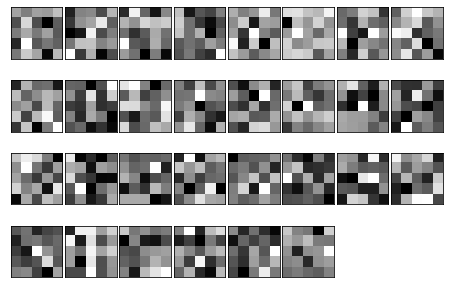

학습후



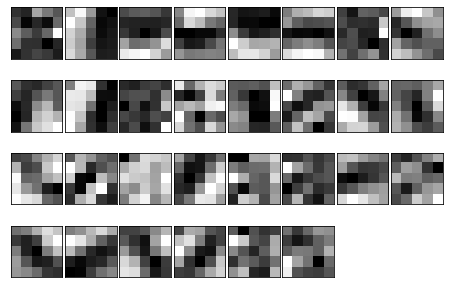

In [21]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
print("학습전\n")
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

print("학습후\n")
# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])


#위 사진에서

위의 CNN 계층에서, CNN계층의 인자로 들어온 w가중치는 

(30,1,5,5)의 4차원이었다. 

즉, 5^5크기의 채널 1개로 이루어진 필터가 30개라는 소리이다.

이를 이미지로 시각화한것이다.(실제로 사진의 갯수는 30개)


**이미지에서는 가장 작은 값(0)은 검은색, 가장 큰 값(255은 흰색으로 정규화한다.**

아래 사진이 의미하는 바는,

학습 전 필터(일종의 가중치)는 무작위로 초기화되어 흑백의 정도에 규칙성이 없다

학습 후 필터는 규칙성 있는 이미지가 된다. ex) 흑백 경계선, 덩어리 등등

#필터가 보고 있는 것(주시하고 있는 것)은 무엇일까??

바로 위에서 말한 경계선(edge)와 덩어리(blob)이다.

**즉, 경계선과 덩어리를 중심으로 값을 최적화하는 과정이다.**

ex) 세로로 경계선이 있는 필터를 적용시키면 출력 이미지의 "세로" 에지가 반응한다

이 과정에서 규칙이 없는 데이터가 규칙이 있는 형태로 바뀐다.

이는, 매개변수의 최적화 과정을 시각화 한 것이라고 볼 수 있다.

#이처럼

합성곱 계층(CNN)의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있다.

이러한 원시적인 정보가 다음 계층에 전달되는 원리이다

#simpleConvNet은 말그대로 "simple"한 Net에 불과하다

simpleconvnet에서, 단순히 합성곱 계층은 1개만 사용했었다.

위의 시각화에서도, 마찬가지로 합성곱 계층이 1개만 있는 신경망을 다루었다.

즉, 합성곱 계층 1개만으로 이루어져 있을때는 에지나 블롭 같은 저수준 정보가 추출된다. (이미지 데이터에서)

✈**하지만, 이러한 CNN을 겹겹이 쌓는다면??** 각 CNN계층에서 어떠한 정보가 추출될까

ex) 일반 사물인식을 수행한 8층의 CNN ( AlexNet 신경망이라고 불립니다)

1번째 층은 에지와 블롭, 3번째 층은 텍스쳐, 5번째 층은 사물의 일부,

마지막 완전연결 계층(Affine)은 사물의 클래스(전체).......... 식이다

#정리하면

최초의 CNN에서는 원시 데이터(아무 규칙이 없는)에서 에지와 블롭을 추출하여 1차로 데이터를 가공하고

그다음 CNN이 겹겹이 이어지면 점점 더 데이터가 가공되어 실제 형태처럼 진화해나간다

이렇게 CNN을 여러겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 **고급** 정보가 추출된다.

다시 말하면, 사물의 의미를 이해하도록 변화한다. 이게 딥러닝의 목표이다.

#대표적인 CNN 

✈1. LeNet

손글씨 숫자를 인식하는 네트워크.

**CNN - (활성화함수) - Pooling 계층의 반복, 마지막은 완전연결 계층**

현재의 CNN(위에서 배운)과 비교하면, 활성화함수로 RELU가 아닌 sigmoid를 사용한것, 

풀링을 최대 풀링이 아닌 서브샘플링(단순히 데이터 크기 줄이기)을 한 것이 있지만

거의 동일하다! 이 네트워크는 1998년,,,에 제안되었다

✈2. AlexNet

LeNet과 유사.

**CNN - (활성화 함수) - Pooling 계층의 반복, 마지막은 완전연결 계층** 

다만

활성화 함수로 RELU를 쓰고

LRN이라는 국소적 정규화를 실시하는 계층 사용(진짜 겹겹이 쌓이는 느낌 구현)

드롭아웃을 사용

등 의 특징이 있다





# 사실

LeNet과 AlexNet의 큰 차이는 없다.

이렇게 여러 네트워크가 개발이 되었지만, 사실 딥러닝의 발전을 이끈 것은

다름 아닌 빅데이터와 GPU 기술 덕분이다. 

**빅데이터** : 대량의 데이터를 누구나 얻을 수 있다. 

-> 매개변수 fitting을 위한 방대한 시험/훈련 데이터를 쉽게 얻을 수 있다.

**GPU** : 병렬 계산에 특화되어 대량의 연산을 고속으로 수행 할 수 있다.

-> 딥러닝의 방대한 매개변수의 학습을 위한 연산과정을 빠르게 할 수 있다.